In [1]:
import pandas as pd
import numpy as np
import glob
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [2]:
def get_meta(path):
    """Returns (threads, num_jsons, repeats)"""
    props = os.path.splitext(os.path.basename(path))[0].split('_')
    values = [int(x[1:]) for x in props[1:]]
    
    return {'max_value':values[0],
            'max_num_values':values[1],
            'threads':values[2],
            'input_size_approx':values[3],
            'repeats':values[4]}

In [3]:
def load(file):
    """Load the experiment data from a CSV file with converter metrics."""
        
    schema = {
        'num_threads': np.int64(),
        'num_jsons_converted': np.int64(),
        'num_json_bytes_converted': np.int64(),
        'num_recordbatch_bytes': np.int64(),
        'num_ipc': np.int64(),
        'ipc_bytes': np.int64(),
        'num_buffers_converted': np.int64(),
        't_parse': np.float64(),
        't_resize': np.float64(),
        't_serialize': np.float64(),
        't_thread': np.float64(),
        't_enqueue': np.float64(),
        'status': np.int64()
    }
    
    df = pd.read_csv(file, dtype=schema)
    
    meta = get_meta(file)

    for key, value in meta.items():  
        df.insert(0, key, value)
        
    # Make sure there were no errors for converters.
    assert(df['status'].sum() == len(df.index))
        
    return df

In [4]:
def analyze(df):
    """Analyze the experiment data, deriving various metrics such as throughput."""
    # Calculate time spent within the thread as 'other'.
    df['t_other'] = df['t_thread'] - df[['t_parse', 't_resize', 't_serialize', 't_enqueue']].sum(axis=1)
    
    # Calculate the throughput per thread
    df['Parse throughput (in)'] = df['num_json_bytes_converted'] / df['t_parse']
    df['Parse throughput (out)'] = df['num_recordbatch_bytes'] / df['t_parse']
    
    return df

In [5]:
def aggr_counts(digit_counts):
    total = 0
    for n, d in digit_counts:
        total = total + n    
    return total
            
def avg_number_of_decimals(max_value):
    ''' Return avg number of decimals of uniform random numbers from 0 up to max_value. '''
    digits = 1
    digit_counts = []
    while (pow(10, digits) < max_value):
        nums = pow(10,digits) - aggr_counts(digit_counts)
        digit_counts.append((nums, digits))
        digits = digits + 1

    digit_counts.append((max_value - aggr_counts(digit_counts), digits))
    
    avg_num_digits = 0
    for n, d in digit_counts:
        avg_num_digits += n/max_value * d
        # print("{} nums with {} digits".format(n, d))
        
    return avg_num_digits

In [6]:
def summarize(df):
    """Summarize the data from one run into one row with averages."""
    
    assert(len(pd.unique(df['max_value'])==1))
    assert(len(pd.unique(df['max_num_values'])==1))
    assert(len(pd.unique(df['threads'])==1))
    assert(len(pd.unique(df['input_size_approx'])==1))
    assert(df['num_threads'].sum()==pd.unique(df['threads'])[0])
    repeats = pd.unique(df['repeats'])[0]
    
    # Avg. value bytes per JSON is the average array size (which is half the max, it is uniform random)
    # times the average number of bytes for uniform random numbers between 0 and max value
    max_value = pd.unique(df['max_value'])[0]
    max_num_values = pd.unique(df['max_num_values'])[0]
    value_bytes = avg_number_of_decimals(max_value) * max_num_values / 2
    
    row = {'Max. value': max_value,
           'Max. number of values': max_num_values,
           'Value bytes': value_bytes,
           'Input size': pd.unique(df['input_size_approx'])[0],
           'Repeats': pd.unique(df['repeats'])[0],
           'Threads': df['num_threads'].sum(),
           'JSONs': df['num_jsons_converted'].sum() / repeats,
           'Bytes (in)': df['num_json_bytes_converted'].sum() / repeats,
           'RecordBatch bytes': df['num_recordbatch_bytes'].sum() / repeats,
           'IPC messages': df['num_ipc'].sum() / repeats,
           'IPC bytes': df['ipc_bytes'].sum() / repeats,
           'Buffers converted': df['num_buffers_converted'].sum() / repeats,
           # For time, we use the max time of all threads, 
           # since the throughput is determined by the slowest thread in the pool,
           # and they all start operating simultaneously
           'Parse time': df['t_parse'].max(),
           'Resize time': df['t_resize'].max(),
           'Serialize time': df['t_serialize'].max(),
           'Enqueue time': df['t_enqueue'].max(),
           'Other time': df['t_other'].max(),
           'Thread time': df['t_thread'].max(),
           'Parse throughput (in)': df['num_json_bytes_converted'].sum() / df['t_parse'].max(),
           'Parse throughput (out)': df['num_recordbatch_bytes'].sum() / df['t_parse'].max()}
              
    return row;

In [7]:
def get_all_data(data_path, schema, impl):
    path = '{}/{}/latency/threads/metrics/{}/'.format(data_path, schema, impl.lower())
    csv_files = []
    for file in glob.glob("{}*.csv".format(path)):
        csv_files.append(file)
    print("Found {} files in {}".format(len(csv_files), path))

    records = []
    for file in csv_files:
        records.append(summarize(analyze(load(file))))


    df = pd.DataFrame.from_records(records)
    df.sort_values(by=['Threads', 'JSONs'], inplace=True)
    df.insert(0,'Implementation', impl)
    
    # Use only best value
    df = df[df['Max. value'] == 18446744073709551615]
    
    # Print max throughput
    display(df['Parse throughput (in)'].max())
    
    return df

In [8]:
def get_max_throughput_for_max_size(df):
    df = df[df.JSONs == df.JSONs.max()]
    #df.set_index('Threads', inplace=True)

    result = df[df['Parse throughput (in)'] == df['Parse throughput (in)'].max()]

    return result

In [9]:
import matplotlib.pyplot as plt
from utils import lighten_color

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

colors = ['#4878d0', '#6acc64', '#d65f5f', '#d5bb67', '#dc7ec0', '#8c613c']
markers = ['o', 's', 'd']

In [10]:
d_impls = []

d_impls.append(get_all_data('../experiments/data-p9', 'battery', 'Arrow'))
d_impls.append(get_all_data('../experiments/data-p9', 'battery', 'Custom'))
d_impls.append(get_all_data('../experiments/data-p9', 'battery', 'FPGA'))

df = pd.concat(d_impls)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
display(df)

# Get all dimensions for plots
#max_values = pd.unique(df['Max. value'])
#max_num_values = pd.unique(df['Max. number of values'])
value_bytes = np.sort(pd.unique(df['Value bytes']))
input_sizes = np.sort(pd.unique(df['Input size']))
threads = np.sort(pd.unique(df['Threads']))
impls = pd.unique(df['Implementation'])

print("Value bytes    :", value_bytes)
print("Input sizes    :", input_sizes)
print("Threads        :", threads)
print("Impls          :", impls)

Found 272 files in ../experiments/data-p9/battery/latency/threads/metrics/arrow/


3970858300.9240265

Found 272 files in ../experiments/data-p9/battery/latency/threads/metrics/custom/


18487980194.67417

Found 16 files in ../experiments/data-p9/battery/latency/threads/metrics/fpga/


17926878174.81353

,Implementation,Max. value,Max. number of values,Value bytes,Input size,Repeats,Threads,JSONs,Bytes (in),RecordBatch bytes,...,IPC bytes,Buffers converted,Parse time,Resize time,Serialize time,Enqueue time,Other time,Thread time,Parse throughput (in),Parse throughput (out)
150,Arrow,18446744073709551615,512,4965.802358,16777216,8,1,3140.0,1.677575e+07,6.574756e+06,...,0.0,1.0,1.963280,0.000007,0.000021,0.000016,0.000056,1.963380,6.835807e+07,2.679091e+07
48,Arrow,18446744073709551615,64,620.725295,16777216,8,1,25302.0,1.677614e+07,6.541828e+06,...,0.0,1.0,1.987640,0.000008,0.000019,0.000018,0.000125,1.987810,6.752186e+07,2.633003e+07
62,Arrow,18446744073709551615,512,4965.802358,134217728,8,1,25728.0,1.342172e+08,5.260164e+07,...,0.0,1.0,15.657400,0.000018,0.000053,0.000033,0.000196,15.657700,6.857700e+07,2.687631e+07
18,Arrow,18446744073709551615,8,77.590662,16777216,8,1,175124.0,1.677720e+07,6.319372e+06,...,0.0,1.0,2.116010,0.000007,0.000019,0.000022,0.000072,2.116130,6.342956e+07,2.389165e+07
127,Arrow,18446744073709551615,64,620.725295,134217728,8,1,201414.0,1.342177e+08,5.233997e+07,...,0.0,1.0,15.808200,0.000016,0.000049,0.000035,0.000199,15.808500,6.792306e+07,2.648750e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,FPGA,18446744073709551615,8,77.590662,1073741824,8,20,11198758.0,1.073740e+09,4.044557e+08,...,0.0,20.0,0.494285,0.000003,0.000017,0.000014,0.003428,0.495822,1.737848e+10,6.546113e+09
2,FPGA,18446744073709551615,64,620.725295,8589934592,8,20,12876481.0,8.589926e+09,3.349790e+09,...,0.0,20.0,4.293580,0.000003,0.000018,0.000015,0.002955,4.295530,1.600515e+10,6.241486e+09
9,FPGA,18446744073709551615,1,9.698833,1073741824,8,20,31215524.0,1.073741e+09,3.745864e+08,...,0.0,20.0,0.490036,0.000004,0.000022,0.000018,0.002393,0.491817,1.752919e+10,6.115247e+09
14,FPGA,18446744073709551615,8,77.590662,8589934592,8,20,89605427.0,8.589933e+09,3.235616e+09,...,0.0,20.0,5.474100,0.000003,0.000015,0.000017,0.002445,5.475840,1.255356e+10,4.728618e+09


Value bytes    : [   9.69883273   77.59066184  620.72529471 4965.80235769]
Input sizes    : [  16777216  134217728 1073741824 8589934592]
Threads        : [  1  11  20  22  33  44  55  66  77  88  99 110 121 132 143 154 165 176]
Impls          : ['Arrow' 'Custom' 'FPGA']


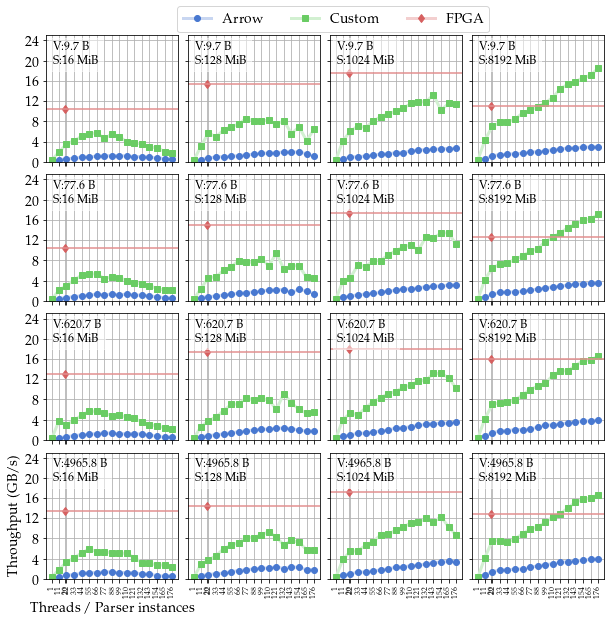

In [17]:
fig, axs = plt.subplots(nrows=len(value_bytes), ncols=len(input_sizes), figsize=(2.5 * len(input_sizes), 2.5 * len(value_bytes)), sharey=True, sharex=True)

handles = {}

for xa, inps in enumerate(input_sizes):
    for ya, valb in enumerate(value_bytes):
        ax = axs[ya][xa]
                
        for i, impl in enumerate(impls):
            # Prepare plotting data
            dl = df[(df['Value bytes'] == valb) & (df['Input size'] == inps) & (df['Implementation'] == impl)]
            y = dl['Parse throughput (in)'] * 1e-9
            x = dl['Threads']
            
            # Plot FPGA data
            handles[impl], = ax.plot(x, y, c=lighten_color(colors[i],0.3), marker=markers[i], mfc=colors[i], mec=colors[i], linewidth=3)
            
            if impl == 'FPGA':
                ax.axhline(y=y.to_numpy()[-1], color=lighten_color(colors[i],0.7))
            
            
            
        # Set inline 
        ax.annotate("V:{:.1f} B\nS:{:.0f} MiB".format(valb, inps / (1<<20)), 
                    xycoords='axes fraction', 
                    xy=(0.05, 0.775), 
                    fontsize=12,
                    backgroundcolor='#FFFFFF80')
        
        ax.set_xticks(threads)
        ax.set_xticklabels(threads, rotation=90, fontsize=8)
        
        ax.set_yticks(range(0, 25,4))
        ax.set_ylim(0, 25)
        
        ax.grid(which='both')
        
        if (ya == len(value_bytes) - 1) and (xa == 0):
            ax.set_xlabel('Threads / Parser instances')
            ax.set_ylabel('Throughput (GB/s)')
                        
leg_handles = [v for k,v in handles.items()]
leg_labels = [k for k,v in handles.items()]
fig.legend(leg_handles, leg_labels, ncol=3, bbox_to_anchor=(-0.25, 0.83, 1.0, 0.1))
plt.subplots_adjust(hspace = .1, wspace = .075)

fig.savefig("throughput.pdf")